# Credit Card Fraud Detection using Light GBM and Cross Validation

## Rebecca Stewart



The data used in this project was taken from a past Kaggle competition and consists of credit card transaction data. The objective of the competition was to build a model that would best predict the probability that an online transaction was fraudulent or not. The metric used to compare models for this binary classification problem, and to score one’s placement in the final results, was the AUC score. 

I am using LightGBM, a gradient boosting framework that uses tree based learning algorithms, so that I can use its ability to estimate feature importance’s. This, in turn, will be used to make decisions on which features to include in the model and the best ones to use for feature engineering.

My motivation for working on this Kaggle project included the following:

<ol><li>Work on a large tabular dataset similar to the one used for a WIDS Kaggle competition that I was anticipating working on in January/February of 2020.<br><br>

<li>Gain experience working with a large dataset, at least one that exceeds the size of the ones I was exposed to in an academic setting. As I anticipated, working with large number of features and rows proved challenging in the following areas:

<ul><li>Figure out tricks that allow one to focus on important features.
<li>Manage computer memory issues.
<li>Employ techniques to test changes in the data for optimal model performance without running the entire dataset through a pipeline every single time. 
</ul></ul>



In [1]:
# I turned off warnings for the fun of this notebook so that the output was cleaner and easier to read
import warnings
warnings.filterwarnings("ignore")

In [86]:
# Import libraries
import datetime as dt
import imblearn
import numpy as np
import matplotlib.pyplot as plt
import re
import gc
import string
import time
import pandas as pd
import scipy.stats as ss
from scipy import stats
import lightgbm as lgb 
from collections import Counter
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.impute import SimpleImputer 
from imblearn.over_sampling import SMOTE 

from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
import seaborn as sns
sns.set()
%matplotlib inline


####  Helper Functions 
The first one, reduce_mem_useage, was taken from an existing kernel on Kaggle:
https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

In [3]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

def predict_evaluate(X_test, y_test, classifier):
    y_pred = classifier.predict(X_test)
    yhat = classifier.predict_proba(X_test)
    pos_probs = yhat[:, 1]
    print("Confusion Matrix")
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    acc_score=accuracy_score(y_test, y_pred)
    print("Accuracy Score " + str(acc_score))
    fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
    
    roc_auc = roc_auc_score(y_test, pos_probs)
    plot_roc_curve(fpr, tpr, roc_auc)
    print("AUC " + str(roc_auc))
    
def plot_roc_curve(fpr, tpr, auc):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
def categorical_encode(df_train, df_test, categorical_features):
    print(len(categorical_features))
    df_train = df_train[categorical_features].astype(str)
    df_test = df_test[categorical_features].astype(str)
     
    ohe = OneHotEncoder(drop='first')
    ohe.fit(pd.concat([df_train, df_test]))

    df_train_values= ohe.transform(df_train).toarray()
    df_train_names= ohe.get_feature_names(categorical_features)
    df_train = pd.DataFrame(df_train_values, columns=df_train_names)

    df_test_values= ohe.transform(df_test).toarray()
    df_test_names= ohe.get_feature_names(categorical_features)
    df_test = pd.DataFrame(df_test_values, columns=df_test_names)
    return df_train, df_test 


 

####  Set some options and thresholds

In [5]:
#setting display options
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 500)
np.set_printoptions(linewidth =400)

# These three options are used for testing purposes
limit_dataset_size= False           # Change this one to True if you do NOT want to load the full dataset
recreate_local_dataset=False        # Change this one to True to re-create a merged, possibly much smaller dataset for testing purposes
max_records=10000                   # Used to limit the number of records, helps speed up testing 

null_thresh=75                      # Drop rows that have more than this percent of missing values
fraction_of_NaN_drop_columns = .90  # Drop columns that have more than this percent of missing values unless they are imporant
drop_rows_with_high_nulls=False     # I toggled this on and off to compare model performance
feature_importance_cutoff = 2000    # Used to filter the number of features considered important (this was average over k-fold)

# Using the following hardcoded datatypes meant that files took up RAM space as they were loaded into memory
# Taken from this kernel... https://www.kaggle.com/mhviraf/reducing-memory-size-an-alternative
proper_dtypes = {'TransactionID': 'UInt32', 'isFraud': 'UInt8', 'TransactionDT': 'UInt32', 'card1': 'UInt16', 'card2': 'UInt16', 'card3': 'UInt8', 'card5': 'UInt8', 'addr1': 'UInt16', 'addr2': 'UInt8', 'dist1': 'UInt16', 'dist2': 'UInt16', 'C1': 'UInt16', 'C2': 'UInt16', 'C3': 'UInt8', 'C4': 'UInt16', 'C5': 'UInt16', 'C6': 'UInt16', 'C7': 'UInt16', 'C8': 'UInt16', 'C9': 'UInt16', 'C10': 'UInt16', 'C11': 'UInt16', 'C12': 'UInt16', 'C13': 'UInt16', 'C14': 'UInt16', 'D1': 'UInt16', 'D2': 'UInt16', 'D3': 'UInt16', 'D5': 'UInt16', 'D7': 'UInt16', 'D10': 'UInt16', 'D13': 'UInt16', 'V1': 'UInt8', 'V2': 'UInt8', 'V3': 'UInt8', 'V4': 'UInt8', 'V5': 'UInt8', 'V6': 'UInt8', 'V7': 'UInt8', 'V8': 'UInt8', 'V9': 'UInt8', 'V10': 'UInt8', 'V11': 'UInt8', 'V12': 'UInt8', 'V13': 'UInt8', 'V14': 'UInt8', 'V15': 'UInt8', 'V16': 'UInt8', 'V17': 'UInt8', 'V18': 'UInt8', 'V19': 'UInt8', 'V20': 'UInt8', 'V21': 'UInt8', 'V22': 'UInt8', 'V23': 'UInt8', 'V24': 'UInt8', 'V25': 'UInt8', 'V26': 'UInt8', 'V27': 'UInt8', 'V28': 'UInt8', 'V29': 'UInt8', 'V30': 'UInt8', 'V31': 'UInt8', 'V32': 'UInt8', 'V33': 'UInt8', 'V34': 'UInt8', 'V35': 'UInt8', 'V36': 'UInt8', 'V37': 'UInt8', 'V38': 'UInt8', 'V39': 'UInt8', 'V40': 'UInt8', 'V41': 'UInt8', 'V42': 'UInt8', 'V43': 'UInt8', 'V44': 'UInt8', 'V45': 'UInt8', 'V46': 'UInt8', 'V47': 'UInt8', 'V48': 'UInt8', 'V49': 'UInt8', 'V50': 'UInt8', 'V51': 'UInt8', 'V52': 'UInt8', 'V53': 'UInt8', 'V54': 'UInt8', 'V55': 'UInt8', 'V56': 'UInt8', 'V57': 'UInt8', 'V58': 'UInt8', 'V59': 'UInt8', 'V60': 'UInt8', 'V61': 'UInt8', 'V62': 'UInt8', 'V63': 'UInt8', 'V64': 'UInt8', 'V65': 'UInt8', 'V66': 'UInt8', 'V67': 'UInt8', 'V68': 'UInt8', 'V69': 'UInt8', 'V70': 'UInt8', 'V71': 'UInt8', 'V72': 'UInt8', 'V73': 'UInt8', 'V74': 'UInt8', 'V75': 'UInt8', 'V76': 'UInt8', 'V77': 'UInt8', 'V78': 'UInt8', 'V79': 'UInt8', 'V80': 'UInt8', 'V81': 'UInt8', 'V82': 'UInt8', 'V83': 'UInt8', 'V84': 'UInt8', 'V85': 'UInt8', 'V86': 'UInt8', 'V87': 'UInt8', 'V88': 'UInt8', 'V89': 'UInt8', 'V90': 'UInt8', 'V91': 'UInt8', 'V92': 'UInt8', 'V93': 'UInt8', 'V94': 'UInt8', 'V95': 'UInt16', 'V96': 'UInt16', 'V97': 'UInt16', 'V98': 'UInt8', 'V99': 'UInt8', 'V100': 'UInt8', 'V101': 'UInt16', 'V102': 'UInt16', 'V103': 'UInt16', 'V104': 'UInt8', 'V105': 'UInt8', 'V106': 'UInt8', 'V107': 'UInt8', 'V108': 'UInt8', 'V109': 'UInt8', 'V110': 'UInt8', 'V111': 'UInt8', 'V112': 'UInt8', 'V113': 'UInt8', 'V114': 'UInt8', 'V115': 'UInt8', 'V116': 'UInt8', 'V117': 'UInt8', 'V118': 'UInt8', 'V119': 'UInt8', 'V120': 'UInt8', 'V121': 'UInt8', 'V122': 'UInt8', 'V123': 'UInt8', 'V124': 'UInt8', 'V125': 'UInt8', 'V138': 'UInt8', 'V139': 'UInt8', 'V140': 'UInt8', 'V141': 'UInt8', 'V142': 'UInt8', 'V143': 'UInt16', 'V144': 'UInt8', 'V145': 'UInt16', 'V146': 'UInt8', 'V147': 'UInt8', 'V148': 'UInt8', 'V149': 'UInt8', 'V150': 'UInt16', 'V151': 'UInt8', 'V152': 'UInt8', 'V153': 'UInt8', 'V154': 'UInt8', 'V155': 'UInt8', 'V156': 'UInt8', 'V157': 'UInt8', 'V158': 'UInt8', 'V167': 'UInt16', 'V168': 'UInt16', 'V169': 'UInt8', 'V170': 'UInt8', 'V171': 'UInt8', 'V172': 'UInt8', 'V173': 'UInt8', 'V174': 'UInt8', 'V175': 'UInt8', 'V176': 'UInt8', 'V177': 'UInt16', 'V178': 'UInt16', 'V179': 'UInt16', 'V180': 'UInt8', 'V181': 'UInt8', 'V182': 'UInt8', 'V183': 'UInt8', 'V184': 'UInt8', 'V185': 'UInt8', 'V186': 'UInt8', 'V187': 'UInt8', 'V188': 'UInt8', 'V189': 'UInt8', 'V190': 'UInt8', 'V191': 'UInt8', 'V192': 'UInt8', 'V193': 'UInt8', 'V194': 'UInt8', 'V195': 'UInt8', 'V196': 'UInt8', 'V197': 'UInt8', 'V198': 'UInt8', 'V199': 'UInt8', 'V200': 'UInt8', 'V201': 'UInt8', 'V217': 'UInt16', 'V218': 'UInt16', 'V219': 'UInt16', 'V220': 'UInt8', 'V221': 'UInt16', 'V222': 'UInt16', 'V223': 'UInt8', 'V224': 'UInt8', 'V225': 'UInt8', 'V226': 'UInt16', 'V227': 'UInt16', 'V228': 'UInt8', 'V229': 'UInt16', 'V230': 'UInt16', 'V231': 'UInt16', 'V232': 'UInt16', 'V233': 'UInt16', 'V234': 'UInt16', 'V235': 'UInt8', 'V236': 'UInt8', 'V237': 'UInt8', 'V238': 'UInt8', 'V239': 'UInt8', 'V240': 'UInt8', 'V241': 'UInt8', 'V242': 'UInt8', 'V243': 'UInt8', 'V244': 'UInt8', 'V245': 'UInt16', 'V246': 'UInt8', 'V247': 'UInt8', 'V248': 'UInt8', 'V249': 'UInt8', 'V250': 'UInt8', 'V251': 'UInt8', 'V252': 'UInt8', 'V253': 'UInt8', 'V254': 'UInt8', 'V255': 'UInt8', 'V256': 'UInt8', 'V257': 'UInt8', 'V258': 'UInt16', 'V259': 'UInt16', 'V260': 'UInt8', 'V261': 'UInt8', 'V262': 'UInt8', 'V279': 'UInt16', 'V280': 'UInt16', 'V281': 'UInt8', 'V282': 'UInt8', 'V283': 'UInt8', 'V284': 'UInt8', 'V285': 'UInt8', 'V286': 'UInt8', 'V287': 'UInt8', 'V288': 'UInt8', 'V289': 'UInt8', 'V290': 'UInt8', 'V291': 'UInt16', 'V292': 'UInt16', 'V293': 'UInt16', 'V294': 'UInt16', 'V295': 'UInt16', 'V296': 'UInt8', 'V297': 'UInt8', 'V298': 'UInt8', 'V299': 'UInt8', 'V300': 'UInt8', 'V301': 'UInt8', 'V302': 'UInt8', 'V303': 'UInt8', 'V304': 'UInt8', 'V305': 'UInt8', 'V322': 'UInt16', 'V323': 'UInt16', 'V324': 'UInt16', 'V325': 'UInt8', 'V326': 'UInt8', 'V327': 'UInt8', 'V328': 'UInt8', 'V329': 'UInt8', 'V330': 'UInt8'}


#### Load Data

Load and merge data from original datasets, or load from already merged local csv files. Show how much memory these sets take up.

In [6]:
# Read Data
if recreate_local_dataset:
    
    train_data_id = pd.read_csv("train_identity.csv", index_col='TransactionID')
    test_data_id = pd.read_csv("test_identity.csv", index_col='TransactionID')

    train_data_tr = pd.read_csv("train_transaction.csv", index_col='TransactionID', dtype=proper_dtypes)
    test_data_tr = pd.read_csv("test_transaction.csv", index_col='TransactionID', dtype=proper_dtypes)

    # Merge Data: The dataset is split into two different datasets, identity and transaction. We need to merge this data on transaction id to create the full set we will use for our model.
    train_data = pd.merge(train_data_tr, train_data_id,how='left', left_index=True, right_index=True)
    test_data = pd.merge(test_data_tr, test_data_id,how='left', left_index=True, right_index=True)

    del train_data_tr,train_data_id
    del test_data_tr, test_data_id    
    gc.collect()
else:   
    train_data = pd.read_csv("fraud_train_data.csv", index_col='TransactionID', dtype=proper_dtypes)
    test_data = pd.read_csv("fraud_test_data.csv", index_col='TransactionID', dtype=proper_dtypes)
    
    
print('Memory usage:', round(train_data.memory_usage(deep=True).sum()/1024/1024, 2), 'MB')
print('Memory usage:', round(test_data.memory_usage(deep=True).sum()/1024/1024, 2), 'MB')

Memory usage: 1641.08 MB
Memory usage: 1423.91 MB


#### Counts of different types of features

In [7]:
train_data.dtypes.value_counts()

UInt8      228
float64    108
UInt16      65
object      31
UInt32       1
dtype: int64

#### Resample and save

Resample to reduce size of datasets (for testing purposes only) and save locally so that we can speed up the loading process. 

In [8]:
# Set recreate_local_dataset to true if you want to re-create these mini datasets.
if recreate_local_dataset: 
    if limit_dataset_size==True:
        train_data = resample(train_data, replace=False, n_samples=max_records, random_state=123) 
        test_data = resample(test_data, replace=False, n_samples=max_records, random_state=123) 
    train_data.to_csv('fraud_train_data.csv')
    test_data.to_csv('fraud_test_data.csv')

#### How big are the data sets?

In [9]:
# Show number of rows and features
print(train_data.shape)
print(test_data.shape)

(590540, 433)
(506691, 432)


#### Examine Data

In [10]:
train_data.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,<NA>,150,discover,142,credit,315,87,19,<NA>,NaN,NaN,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14,<NA>,13,NaN,<NA>,NaN,<NA>,NaN,NaN,13,13.0,NaN,<NA>,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [10]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3.027058e+06,7.306528e+06,1.124662e+07,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,4.332100e+01,6.876900e+01,1.250000e+02,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6.019000e+03,9.678000e+03,1.418400e+04,1.839600e+04
card2,581607.0,3.625555e+02,1.577932e+02,100.000,2.140000e+02,3.610000e+02,5.120000e+02,6.000000e+02
card3,588975.0,1.531949e+02,1.133644e+01,100.000,1.500000e+02,1.500000e+02,1.500000e+02,2.310000e+02
card5,586281.0,1.992789e+02,4.124445e+01,100.000,1.660000e+02,2.260000e+02,2.260000e+02,2.370000e+02
addr1,524834.0,2.907338e+02,1.017411e+02,100.000,2.040000e+02,2.990000e+02,3.300000e+02,5.400000e+02
addr2,524834.0,8.680063e+01,2.690623e+00,10.000,8.700000e+01,8.700000e+01,8.700000e+01,1.020000e+02
dist1,238269.0,1.185022e+02,3.718720e+02,0.000,3.000000e+00,8.000000e+00,2.400000e+01,1.028600e+04


In [11]:
train_data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: UInt16(65), UInt32(1), UInt8(228), float64(108), object(31)
memory usage: 1000.2+ MB


In [12]:
train_data.isnull().sum()

isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022


In [13]:
test_data.isnull().sum()

TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8654
card3               3002
card4               3086
card5               4547
card6               3007
addr1              65609
addr2              65609
dist1             291217
dist2             470255
P_emaildomain      69192
R_emaildomain     370821
C1                     3
C2                     3
C3                     3
C4                     3
C5                     3
C6                     3
C7                     3
C8                     3
C9                     3
C10                    3
C11                    3
C12                    3
C13                 4748
C14                    3
D1                  6031
D2                234769
D3                203142
D4                 76851
D5                224375
D6                381908
D7                446558
D8                432353
D9                432353
D10                12545
D11               176518


<b>Compare null values between the train and test sets</b>

It’s interesting that we see nulls in at least one C feature in the test set but not in the train set. According to the data description on Kaggle, C1-C14 features represents counts, such as how many addresses are found to be associated with the payment card, etc. Even though the actual meaning is masked, it seems to make sense to replace missing values with zero, instead of the mean of all the non-null values, since missing data probably has the same meaning as zero matches.

I could use a regular expression to check each column name to see if it begins with a C, but the following code is a little more obvious what I am trying to do.

In [14]:
C_features = ['C1', 'C2','C3','C4', 'C5','C6','C7', 'C8','C9','C10', 'C11','C12','C13', 'C14']

# Set Nulls to Zeros for these features
for col in C_features:
    if train_data[col].isna().sum()>0:
        HasNan = np.isnan(train_data[col])
        train_data.loc[HasNan, col] = 0
            
    if test_data[col].isna().sum()>0:
        HasNan = np.isnan(test_data[col])
        test_data.loc[HasNan, col] = 0

In [15]:
display(train_data.nunique())

isFraud                2
TransactionDT     573349
TransactionAmt     20902
ProductCD              5
card1              13553
card2                500
card3                114
card4                  4
card5                119
card6                  4
addr1                332
addr2                 74
dist1               2651
dist2               1751
P_emaildomain         59
R_emaildomain         60
C1                  1657
C2                  1216
C3                    27
C4                  1260
C5                   319
C6                  1328
C7                  1103
C8                  1253
C9                   205
C10                 1231
C11                 1476
C12                 1199
C13                 1597
C14                 1108
D1                   641
D2                   641
D3                   649
D4                   808
D5                   688
D6                   829
D7                   597
D8                 12353
D9                    24
D10                  818


#### Split Data 

Separate our independent features from our dependent features, then delete the old dataframes.

Our dependent feature, or label, is the 'isFraud' column.

In [15]:
X = train_data
test_X=test_data
test_X.columns = [col for col in X.columns if col != 'isFraud']
del test_data,  train_data
gc.collect()

0

#### Non-Numeric Features and their Unique Values

We can grab a list of columns that are not numeric (by filtering on just those that are of type object) and look at the unique values and counts for each. 

In [16]:
cat_cols = list(X.select_dtypes(include=['object']).columns)
print("Number of category/string features: " + str(len(cat_cols)))

for col in cat_cols:
    print('-'*30)
    print(col)
    print(X[col].value_counts().sort_index())
  

Number of category/string features: 31
------------------------------
ProductCD
C     68519
H     33024
R     37699
S     11628
W    439670
Name: ProductCD, dtype: int64
------------------------------
card4
american express      8328
discover              6651
mastercard          189217
visa                384767
Name: card4, dtype: int64
------------------------------
card6
charge card            15
credit             148986
debit              439938
debit or credit        30
Name: card6, dtype: int64
------------------------------
P_emaildomain
aim.com                315
anonymous.com        36998
aol.com              28289
att.net               4033
bellsouth.net         1909
cableone.net           159
centurylink.net        205
cfl.rr.com             172
charter.net            816
comcast.net           7888
cox.net               1393
earthlink.net          514
embarqmail.com         260
frontier.com           280
frontiernet.net        195
gmail                  496
gmail.com      

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64
------------------------------
DeviceInfo
0PAJ5                                              1
0PJA2                                              1
0PM92                                              4
1016S                                              1
2PQ93                                              1
2PS64 Build/NRD90M                                 6
2PYB2                                              4
2PZC5                                              2
4003A                                              1
4009F                                              2
4013M Build/KOT49H                                13
4027A Build/KOT49H                                 2
4034E                                              1
4034G                                              1
4047A Build/NRD90M                                 7
4047G Build/NRD90M                                17
47418                                        

#### Datatypes

In [17]:
X.dtypes

isFraud             UInt8
TransactionDT      UInt32
TransactionAmt    float64
ProductCD          object
card1              UInt16
card2              UInt16
card3               UInt8
card4              object
card5               UInt8
card6              object
addr1              UInt16
addr2               UInt8
dist1              UInt16
dist2              UInt16
P_emaildomain      object
R_emaildomain      object
C1                 UInt16
C2                 UInt16
C3                  UInt8
C4                 UInt16
C5                 UInt16
C6                 UInt16
C7                 UInt16
C8                 UInt16
C9                 UInt16
C10                UInt16
C11                UInt16
C12                UInt16
C13                UInt16
C14                UInt16
D1                 UInt16
D2                 UInt16
D3                 UInt16
D4                float64
D5                 UInt16
D6                float64
D7                 UInt16
D8                float64
D9          

<b>Category Features</b>

After careful review, we will make sure these should be category features:

In [18]:
convert_to_category=['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21',
    'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31',
    'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
    'DeviceType', 'DeviceInfo', 'ProductCD', 'P_emaildomain', 'R_emaildomain',
    'card4',  'card6',
    'addr1', 'addr2',
    'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

print("There are " + str(len(cat_cols)) + " features that are already of type object")
print("There should be " + str(len(convert_to_category))+ " features that are already of type object")
converted_to_category = [col for col in convert_to_category if col not in cat_cols ]
print("We still need to convert the following features to type category or object")
print(converted_to_category)

There are 31 features that are already of type object
There should be 45 features that are already of type object
We still need to convert the following features to type category or object
['id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32', 'addr1', 'addr2']



#### Forward/Back Fill Missing Values for Some Categorical Features 

I added/removed various categorical features to this section, as well as toggled each between forward and backward fill to test the effect each change had on the model performance. This is what I ended up with as optimal.

In [19]:
print("Address 2 values before f fill")
print(X['addr2'].value_counts().sort_index())

X['M4'].fillna(method='bfill',inplace = True)
test_X['M4'].fillna(method='bfill',inplace = True)

X['M6'].fillna(method='ffill',inplace = True)
test_X['M6'].fillna(method='ffill',inplace = True)


X['M2'].fillna(method='ffill',inplace = True)
test_X['M2'].fillna(method='ffill',inplace = True)

print("Address 2 values after f fill")
print(X['addr2'].value_counts().sort_index())

Address 2 values before f fill
10          8
13          7
14          1
15          1
16         55
17          7
18          3
19         33
20          3
21          5
22          1
23          2
24          3
25          1
26         25
27         20
28          4
29         11
30          4
31         47
32         91
34         16
35          1
36          2
38          3
39          3
40          3
43         12
44          3
46          3
47          4
48          4
49          1
50          1
51          4
52          5
54          6
55          1
57         10
59         17
60       3084
61          3
62          4
63          2
65         82
66          2
68         10
69         17
70          1
71          7
72          6
73          5
74          3
75          1
76          2
77          1
78          8
79          1
82          1
83          1
84          1
86          2
87     520481
88          5
89          1
92          2
93          1
94          1
96        638
97 

#### Convert some features to type string

In [20]:
for col in convert_to_category:
    X[col] = X[col].astype('str')
    test_X[col] =test_X[col].astype('str')

#### Load list of Important Features

The code in this notebook was run iteratively to figure out which features have higher importance than others. Near the end of this notebook, we built a LGBMClassifier and used its ability to estimate feature importance’s (averaged over 5 folds). The feature importance averages were saved as a csv file and then re-loaded on the next iteration to us in data analysis and to help decide which features can be dropped or not.

In [21]:
# Load feture importances, which were created during the last run of this notebook
feature_imp_df = pd.read_csv('feature_importancesv2.csv')
feature_imp_df.head(15)

,Unnamed: 0,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
0,0,TransactionDT,16265,16782,16112,16137,16886,16436.4
1,1,TransactionAmt,17477,17290,17116,17971,17973,17565.4
2,2,card1,19203,19995,18909,19784,19200,19418.2
3,3,card2,19611,19170,20212,18872,19666,19506.2
4,4,card3,3682,3510,3566,3603,3745,3621.2
5,5,card5,11122,11390,11091,11832,11520,11391.0
6,6,addr1,21826,22059,22852,21246,20964,21789.4
7,7,addr2,816,814,793,691,788,780.4
8,8,dist1,5931,5710,5786,5817,5555,5759.8
9,9,C1,7916,7717,7866,7857,7518,7774.8


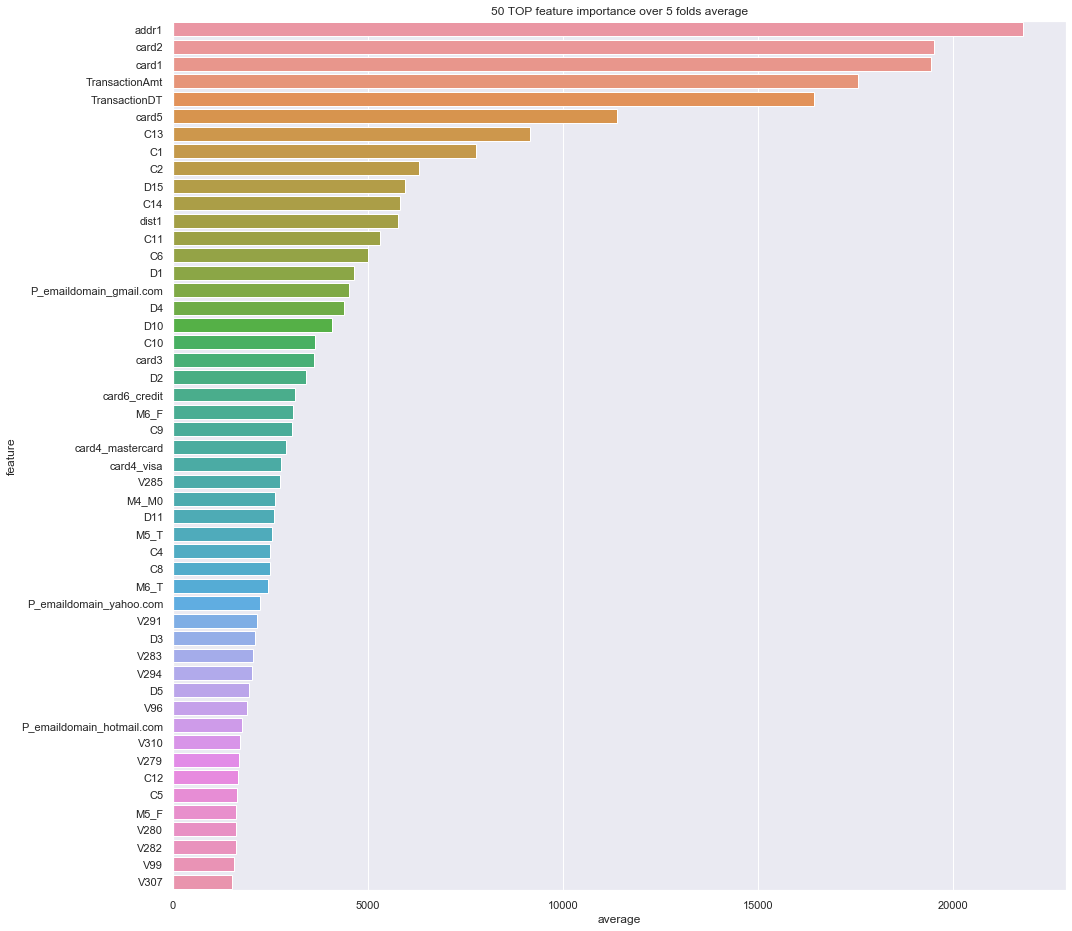

In [22]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_imp_df.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(5));


In [ ]:
# Filter out those features with the highest importance

top_feature_imp_df=feature_imp_df[feature_imp_df.average > feature_importance_cutoff].sort_values('average', ascending=False)
top_features = top_feature_imp_df['feature'].to_list()

# Feature that were not one-hot-encoded
regular_columns = [col for col in top_features if col  in X.columns]

# Feature that were one-hot-encoded - If we list these out, we will be able to figure out the feature before it was encoded
encoded_columns = [col for col in top_features if col not in X.columns]

In [24]:
sorted(encoded_columns)

['M4_M0',
 'M5_T',
 'M6_F',
 'M6_T',
 'P_emaildomain_gmail.com',
 'P_emaildomain_yahoo.com',
 'card4_mastercard',
 'card4_visa',
 'card6_credit']

#### Add to our list of important features
We can figure out which encoded fields have high importance by looking at this list and manually adding the corresponding column names to our array. I know from research that ProductCD is also important, so I manually added that feature as well.

In [25]:

more_regular_columns=[ 'M4', 'M5', 'M6', 'P_emaildomain', 'ProductCD', 'card4', 'card6']
regular_columns=regular_columns + more_regular_columns
len(regular_columns)

36

<b>View List of Important Features</b>

Separate these out into numeric and categorical features.

In [26]:
obj_columns= [col for col in X.columns if X[col].dtypes == 'object']
important_cat_columns = [col for col in regular_columns if col in obj_columns]
print("Important Category Columns " + str(important_cat_columns))
important_num_columns = [col for col in regular_columns if col not in obj_columns]
print("Important Numeric Columns " + str(important_num_columns))

Important Category Columns ['addr1', 'M4', 'M5', 'M6', 'P_emaildomain', 'ProductCD', 'card4', 'card6']
Important Numeric Columns ['card2', 'card1', 'TransactionAmt', 'TransactionDT', 'card5', 'C13', 'C1', 'C2', 'D15', 'C14', 'dist1', 'C11', 'C6', 'D1', 'D4', 'D10', 'C10', 'card3', 'D2', 'C9', 'V285', 'D11', 'C4', 'C8', 'V291', 'D3', 'V283', 'V294']


#### Dropping columns/features

If all values in a particular feature are missing or unique, we can drop them. But, make sure that we drop the same features from both sets of data.

In [27]:
# First get a list of all columns from both dataframes, we want to make sure we drop these columns from both dataframes
drop_cols = set(list(X.columns[X.nunique() <= 1]) + list(test_X.columns[test_X.nunique() <= 1]))
X.drop([col for col in drop_cols if col in X.columns],  axis=1, inplace=True)
test_X.drop([col for col in drop_cols if col in test_X.columns],  axis=1, inplace=True)
drop_cols

{'V107'}

In [28]:
gc.collect()

11383


#### Dropping columns/features continued

Remove those with a high number of missing values unless they are important.

In [29]:
# Create a dataframe of the columns that have more than a certain percentage missing values
isna_counts = X.isna().sum()
isna_counts = pd.DataFrame({'col':isna_counts.index, 'cnt':isna_counts.values})
isna_counts["pct"] = isna_counts['cnt']/X.shape[0]
isna_counts = isna_counts[isna_counts.loc[:, "pct"] >  fraction_of_NaN_drop_columns] 
isna_counts.sort_values(by=['col']).head(100)
drop_cols = list(isna_counts['col'])
drop_cols = [col for col in drop_cols if col not in regular_columns]


In [30]:
drop_cols

['dist2', 'D7', 'id_07', 'id_08']

In [31]:
print("Number of columns to drop: " + str(len(drop_cols)))
X.drop(drop_cols, axis=1, inplace=True)
test_X.drop(drop_cols, axis=1, inplace=True)

Number of columns to drop: 4


#### Replace infinity values with NaN

We will deal with NaN's a little later.

In [32]:
X.replace([np.inf, -np.inf], np.nan,inplace=True)
test_X.replace([np.inf, -np.inf], np.nan,inplace=True)


#### Dropping columns/features continued

Drop features that have an average importance value of less than 1000 (except categorical features)

In [33]:
bottom_feature_imp_df=feature_imp_df[feature_imp_df.average < 1000].sort_values('average', ascending=False)
bottom_features = bottom_feature_imp_df['feature'].to_list()
bottom_features = [col for col in bottom_features if col in X.columns]
X.drop(bottom_features, axis=1, inplace=True)
test_X.drop(bottom_features, axis=1, inplace=True)
del feature_imp_df, top_feature_imp_df, bottom_feature_imp_df
gc.collect()

0

#### Impute Missing Values

In [34]:
num_cols = [col for col in X.columns if X[col].dtypes in ['float16', 'float32', 'float64']]
# Impute the rest of the numeric columns to be the mean
test_X['isFraud']=0
for col in X.columns:
    if X[col].dtypes in ['float16', 'float32', 'float64']:
        if X[col].isna().sum()>0:
            HasNan = np.isnan(X[col])
            X.loc[HasNan, col] = np.nanmean(X[col])
            
        if test_X[col].isna().sum()>0:
            HasNan = np.isnan(test_X[col])
            test_X.loc[HasNan, col] = np.nanmean(test_X[col])
    if X[col].dtypes in ['int8','int16','int32','UInt8', 'UInt16', 'Int16' ]:
        if X[col].isna().sum()>0:
            X[col].fillna(X[col].median(),inplace=True)
        if test_X[col].isna().sum()>0:
            test_X[col].fillna(X[col].median(),inplace=True)
   

In [35]:
test_X.drop('isFraud', axis=1, inplace=True)

#### Replace Outliers 

In [36]:
replace_outliers=True
if replace_outliers:
    for col in X.columns:
        if X[col].dtypes in ['float64', 'float32','float16']:
            TooHighOrLow =  (X.loc[:, col] >   X[col].mean() + 3 * X[col].std()) | (X.loc[:, col] <   X[col].mean() - 3 * X[col].std())
            X.loc[TooHighOrLow, col] = np.nanmean(X.loc[~TooHighOrLow,col])
    for col in test_X.columns:
        if test_X[col].dtypes in ['float64', 'float32','float16']:
            TooHighOrLow =  (test_X.loc[:, col] >   test_X[col].mean() + 3 * test_X[col].std()) | (test_X.loc[:, col] <   test_X[col].mean() - 3 * test_X[col].std())
            test_X.loc[TooHighOrLow, col] = np.nanmean(test_X.loc[~TooHighOrLow,col])
            


#### Free up some memory?

In [38]:
X, NAlist = reduce_mem_usage(X)

Memory usage of properties dataframe is : 755.5167770385742  MB
******************************
Column:  isFraud
dtype before:  UInt8
min for this col:  0
max for this col:  1
dtype after:  uint8
******************************
******************************
Column:  TransactionDT
dtype before:  UInt32
min for this col:  86400
max for this col:  15811131
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
min for this col:  0.251
max for this col:  852.47
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  UInt16
min for this col:  1000
max for this col:  18396
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  UInt16
min for this col:  100
max for this col:  600
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  UInt8
min for t

dtype after:  uint16
******************************
******************************
Column:  V99
dtype before:  UInt8
min for this col:  0
max for this col:  88
dtype after:  uint8
******************************
******************************
Column:  V102
dtype before:  UInt16
min for this col:  0
max for this col:  1285
dtype after:  uint16
******************************
******************************
Column:  V138
dtype before:  UInt8
min for this col:  0
max for this col:  22
dtype after:  uint8
******************************
******************************
Column:  V139
dtype before:  UInt8
min for this col:  0
max for this col:  33
dtype after:  uint8
******************************
******************************
Column:  V140
dtype before:  UInt8
min for this col:  0
max for this col:  33
dtype after:  uint8
******************************
******************************
Column:  V141
dtype before:  UInt8
min for this col:  0
max for this col:  5
dtype after:  uint8
*****************

******************************
******************************
Column:  V189
dtype before:  UInt8
min for this col:  0
max for this col:  30
dtype after:  uint8
******************************
******************************
Column:  V190
dtype before:  UInt8
min for this col:  0
max for this col:  42
dtype after:  uint8
******************************
******************************
Column:  V191
dtype before:  UInt8
min for this col:  0
max for this col:  21
dtype after:  uint8
******************************
******************************
Column:  V192
dtype before:  UInt8
min for this col:  0
max for this col:  44
dtype after:  uint8
******************************
******************************
Column:  V193
dtype before:  UInt8
min for this col:  0
max for this col:  37
dtype after:  uint8
******************************
******************************
Column:  V194
dtype before:  UInt8
min for this col:  0
max for this col:  7
dtype after:  uint8
******************************
**********

dtype after:  uint8
******************************
******************************
Column:  V247
dtype before:  UInt8
min for this col:  0
max for this col:  18
dtype after:  uint8
******************************
******************************
Column:  V248
dtype before:  UInt8
min for this col:  0
max for this col:  36
dtype after:  uint8
******************************
******************************
Column:  V249
dtype before:  UInt8
min for this col:  0
max for this col:  22
dtype after:  uint8
******************************
******************************
Column:  V250
dtype before:  UInt8
min for this col:  0
max for this col:  18
dtype after:  uint8
******************************
******************************
Column:  V251
dtype before:  UInt8
min for this col:  0
max for this col:  18
dtype after:  uint8
******************************
******************************
Column:  V252
dtype before:  UInt8
min for this col:  0
max for this col:  24
dtype after:  uint8
********************

dtype after:  float32
******************************
******************************
Column:  V333
dtype before:  float64
min for this col:  0.0
max for this col:  9923.0
dtype after:  float32
******************************
******************************
Column:  V334
dtype before:  float64
min for this col:  0.0
max for this col:  280.0
dtype after:  float32
******************************
******************************
Column:  V335
dtype before:  float64
min for this col:  0.0
max for this col:  491.0
dtype after:  float32
******************************
******************************
Column:  V336
dtype before:  float64
min for this col:  0.0
max for this col:  335.0
dtype after:  float32
******************************
******************************
Column:  V337
dtype before:  float64
min for this col:  0.0
max for this col:  800.0
dtype after:  float32
******************************
******************************
Column:  V338
dtype before:  float64
min for this col:  0.0
max for th

In [40]:
test_X, NAlist = reduce_mem_usage(test_X)

Memory usage of properties dataframe is : 650.1165237426758  MB
******************************
Column:  TransactionDT
dtype before:  UInt32
min for this col:  18403224
max for this col:  34214345
dtype after:  uint32
******************************
******************************
Column:  TransactionAmt
dtype before:  float64
min for this col:  0.018000000000000002
max for this col:  872.0
dtype after:  float32
******************************
******************************
Column:  card1
dtype before:  UInt16
min for this col:  1001
max for this col:  18397
dtype after:  uint16
******************************
******************************
Column:  card2
dtype before:  UInt16
min for this col:  100
max for this col:  600
dtype after:  uint16
******************************
******************************
Column:  card3
dtype before:  UInt8
min for this col:  100
max for this col:  232
dtype after:  uint8
******************************
******************************
Column:  card5
dtype befor

min for this col:  0
max for this col:  62
dtype after:  uint8
******************************
******************************
Column:  V102
dtype before:  UInt16
min for this col:  0
max for this col:  68
dtype after:  uint8
******************************
******************************
Column:  V138
dtype before:  UInt8
min for this col:  0
max for this col:  20
dtype after:  uint8
******************************
******************************
Column:  V139
dtype before:  UInt8
min for this col:  0
max for this col:  28
dtype after:  uint8
******************************
******************************
Column:  V140
dtype before:  UInt8
min for this col:  0
max for this col:  59
dtype after:  uint8
******************************
******************************
Column:  V141
dtype before:  UInt8
min for this col:  0
max for this col:  6
dtype after:  uint8
******************************
******************************
Column:  V142
dtype before:  UInt8
min for this col:  0
max for this col:  

dtype after:  float32
******************************
******************************
Column:  V203
dtype before:  float64
min for this col:  0.0
max for this col:  15000.0
dtype after:  float32
******************************
******************************
Column:  V204
dtype before:  float64
min for this col:  0.0
max for this col:  13000.0673828125
dtype after:  float32
******************************
******************************
Column:  V205
dtype before:  float64
min for this col:  0.0
max for this col:  875.0
dtype after:  float32
******************************
******************************
Column:  V206
dtype before:  float64
min for this col:  0.0
max for this col:  625.2515869140625
dtype after:  float32
******************************
******************************
Column:  V207
dtype before:  float64
min for this col:  0.0
max for this col:  1450.0
dtype after:  float32
******************************
******************************
Column:  V208
dtype before:  float64
min for 

dtype after:  uint8
******************************
******************************
Column:  V262
dtype before:  UInt8
min for this col:  0
max for this col:  34
dtype after:  uint8
******************************
******************************
Column:  V263
dtype before:  float64
min for this col:  0.0
max for this col:  12460.8876953125
dtype after:  float32
******************************
******************************
Column:  V264
dtype before:  float64
min for this col:  0.0
max for this col:  14619.1435546875
dtype after:  float32
******************************
******************************
Column:  V265
dtype before:  float64
min for this col:  0.0
max for this col:  14055.986328125
dtype after:  float32
******************************
******************************
Column:  V266
dtype before:  float64
min for this col:  0.0
max for this col:  1000.0
dtype after:  float32
******************************
******************************
Column:  V267
dtype before:  float64
min for this

min for this col:  -1.0
max for this col:  0.0
dtype after:  float32
******************************
******************************
Column:  id_05
dtype before:  float64
min for this col:  -6.0
max for this col:  9.0
dtype after:  float32
******************************
******************************
Column:  id_06
dtype before:  float64
min for this col:  -31.0
max for this col:  0.0
dtype after:  float32
******************************
******************************
Column:  id_09
dtype before:  float64
min for this col:  -1.0
max for this col:  1.0
dtype after:  float32
******************************
******************************
Column:  id_10
dtype before:  float64
min for this col:  -2.0
max for this col:  0.0
dtype after:  float32
******************************
******************************
Column:  id_11
dtype before:  float64
min for this col:  98.02999877929688
max for this col:  100.0
dtype after:  float32
******************************
___MEMORY USAGE AFTER COMPLETION:___
Me

### Review our target variable

There are about 30 times more 'non-fraud' records than 'fraud' records.

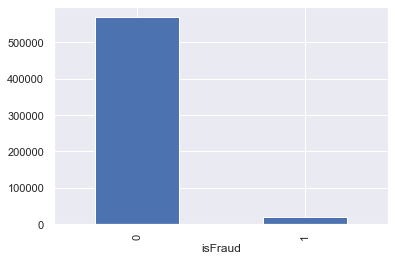

In [42]:
X.groupby(['isFraud']).size().plot.bar()
plt.show()

In [43]:
data_maj = X[X['isFraud']==0]
data_min = X[X['isFraud']==1]

n_fraud=data_maj.shape[0]
fraud=data_min.shape[0]
print("Total Non-Fraud " + str(n_fraud))
print("Total Fraud " + str(fraud))
print("Percent Non-Fraud %" + str(n_fraud/(fraud + n_fraud)*100))
print("Percent Fraud %" + str(fraud/(fraud + n_fraud)*100))

Total Non-Fraud 569877
Total Fraud 20663
Percent Non-Fraud %96.50099908558268
Percent Fraud %3.4990009144173126


In [44]:
del data_maj, data_min, n_fraud, fraud
gc.collect()

2450

#### Review Distributions of High Importance Features by Fraud

In [45]:
regular_columns = [col for col in regular_columns if col in X.columns]

hi_num_columns = [col for col in regular_columns if X[col].dtypes != 'object']
hi_obj_columns= [col for col in regular_columns if X[col].dtypes == 'object']


print("There are " +str(len(hi_obj_columns)) + " category/string features with high importance, they are; ")
print(hi_obj_columns)
print("-"*75)
print("There are " +str(len(hi_num_columns)) + " numeric features with high importance, they are; ")
print(hi_num_columns)
print("-"*75)


There are 8 category/string features with high importance, they are; 
['addr1', 'M4', 'M5', 'M6', 'P_emaildomain', 'ProductCD', 'card4', 'card6']
---------------------------------------------------------------------------
There are 28 numeric features with high importance, they are; 
['card2', 'card1', 'TransactionAmt', 'TransactionDT', 'card5', 'C13', 'C1', 'C2', 'D15', 'C14', 'dist1', 'C11', 'C6', 'D1', 'D4', 'D10', 'C10', 'card3', 'D2', 'C9', 'V285', 'D11', 'C4', 'C8', 'V291', 'D3', 'V283', 'V294']
---------------------------------------------------------------------------


#### Review Distribution for Select Category Features by Fraud/Not Fraud

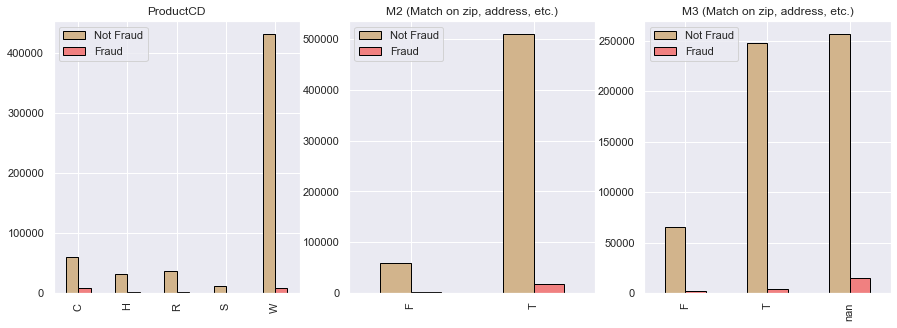

In [46]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
colors=["tan", "lightcoral"]

df_by_int_cat1 = X.groupby(['isFraud','ProductCD']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['isFraud'],  index = "ProductCD",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
axes[0].set_xlabel("")
axes[0].set_title("ProductCD")
axes[0].legend(('Not Fraud', 'Fraud'))



df_by_int_cat3 = X.groupby(['isFraud','M2']).size().reset_index(name='Count')
df_by_int_cat_pivot3 = pd.pivot_table(df_by_int_cat3,  values='Count',  columns=['isFraud'],  index = "M2",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot3.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[1])
axes[1].set_xlabel("")
axes[1].set_title("M2 (Match on zip, address, etc.)")
axes[1].legend(('Not Fraud', 'Fraud'))

df_by_int_cat4 = X.groupby(['isFraud','M3']).size().reset_index(name='Count')
df_by_int_cat_pivot4 = pd.pivot_table(df_by_int_cat4,  values='Count',  columns=['isFraud'],  index = "M3",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot4.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[2])
axes[2].set_xlabel("")
axes[2].set_title("M3 (Match on zip, address, etc.)")
axes[2].legend(('Not Fraud', 'Fraud'))



In [47]:
del df_by_int_cat1, df_by_int_cat_pivot1
del df_by_int_cat3, df_by_int_cat_pivot3
del df_by_int_cat4, df_by_int_cat_pivot4
gc.collect()

234

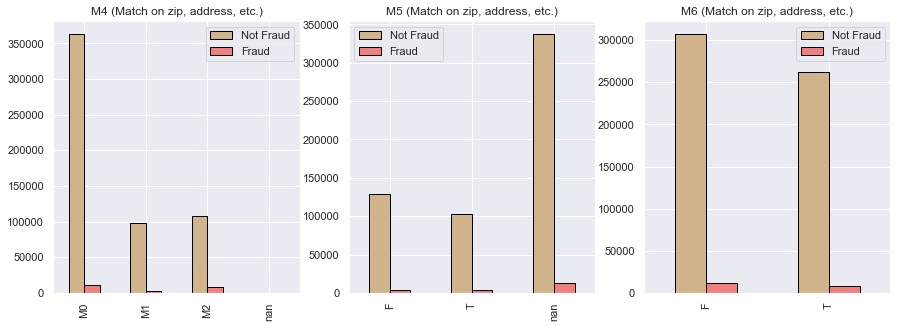

In [48]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = X.groupby(['isFraud','M4']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['isFraud'],  index = "M4",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
axes[0].set_xlabel('')
axes[0].set_title("M4 (Match on zip, address, etc.)")
axes[0].legend(('Not Fraud', 'Fraud'))

df_by_int_cat2 = X.groupby(['isFraud','M5']).size().reset_index(name='Count')
df_by_int_cat_pivot2 = pd.pivot_table(df_by_int_cat2,  values='Count',  columns=['isFraud'],  index = "M5",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot2.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[1])
axes[1].set_xlabel("")
axes[1].set_title("M5 (Match on zip, address, etc.)")
axes[1].legend(('Not Fraud', 'Fraud'))


df_by_int_cat3 = X.groupby(['isFraud','M6']).size().reset_index(name='Count')
df_by_int_cat_pivot3 = pd.pivot_table(df_by_int_cat3,  values='Count',  columns=['isFraud'],  index = "M6",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot3.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[2])
axes[2].set_xlabel("")
axes[2].set_title("M6 (Match on zip, address, etc.)")
axes[2].legend(('Not Fraud', 'Fraud'))
plt.show()

In [49]:
del df_by_int_cat1, df_by_int_cat_pivot1
del df_by_int_cat2, df_by_int_cat_pivot2
del df_by_int_cat3, df_by_int_cat_pivot3
gc.collect()

234

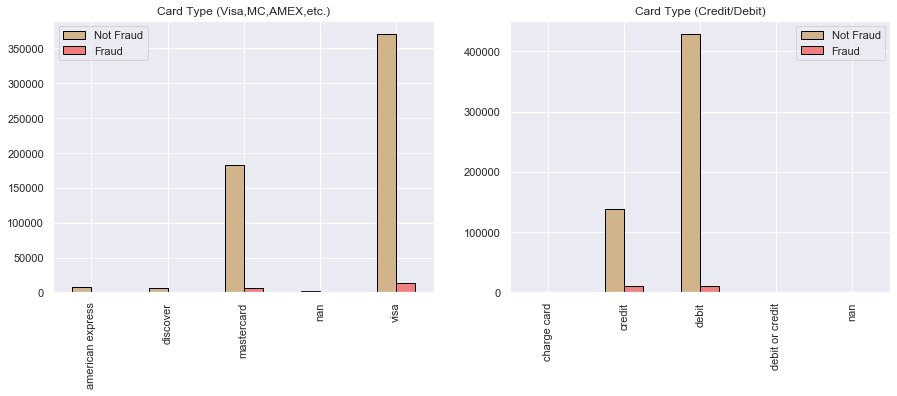

In [50]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
colors=["tan", "lightcoral"]
df_by_int_cat1 = X.groupby(['isFraud','card4']).size().reset_index(name='Count')
df_by_int_cat_pivot1 = pd.pivot_table(df_by_int_cat1,  values='Count',  columns=['isFraud'],  index = "card4",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot1.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[0])
axes[0].set_xlabel('')
axes[0].set_title("Card Type (Visa,MC,AMEX,etc.)")
axes[0].legend(('Not Fraud', 'Fraud'))

df_by_int_cat2 = X.groupby(['isFraud','card6']).size().reset_index(name='Count')
df_by_int_cat_pivot2 = pd.pivot_table(df_by_int_cat2,  values='Count',  columns=['isFraud'],  index = "card6",
                         aggfunc=np.sum,  fill_value=0)
df_by_int_cat_pivot2.plot(kind="bar",  edgecolor='black',color=colors, ax = axes[1])
axes[1].set_xlabel("")
axes[1].set_title("Card Type (Credit/Debit)")
axes[1].legend(('Not Fraud', 'Fraud'))




plt.show()

In [51]:
del df_by_int_cat1, df_by_int_cat_pivot1
del df_by_int_cat2, df_by_int_cat_pivot2
gc.collect()

8444

#### Create a new feature: TransactionAmt_decimal

Decimal part of transaction amount.

In [52]:
X['TransactionAmt_decimal'] = ((X['TransactionAmt'] - X['TransactionAmt'].astype(int)) * 1000).astype(int)
test_X['TransactionAmt_decimal'] = ((test_X['TransactionAmt'] - test_X['TransactionAmt'].astype(int)) * 1000).astype(int)

#### Review Distributions of Transaction Amount and the Decimal Portion of Transaction Amount

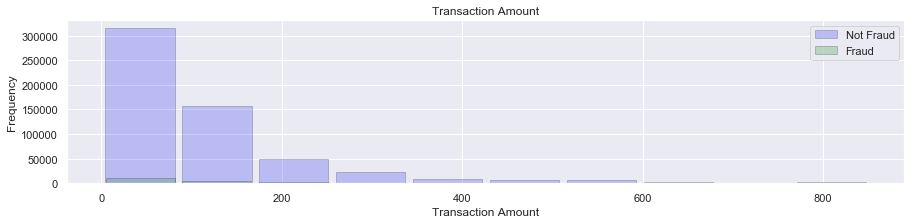

In [53]:
fig, axes = plt.subplots(1,1, figsize=(15, 3))
X.loc[X["isFraud"]==0, "TransactionAmt" ].plot.hist( rwidth=0.9, title='Transaction Amount', edgecolor='black', alpha=0.2, color="blue", ax = axes)
X.loc[X["isFraud"]!=0, "TransactionAmt" ].plot.hist( rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes)
axes.set_xlabel("Transaction Amount")
axes.legend(('Not Fraud', 'Fraud'))
plt.show()

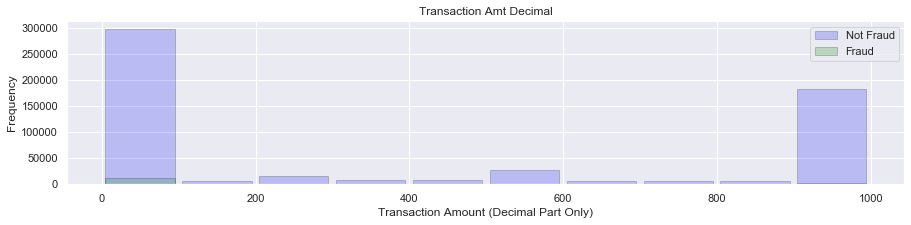

In [54]:
fig, axes = plt.subplots(1,1, figsize=(15, 3))
X.loc[X["isFraud"]==0, "TransactionAmt_decimal" ].plot.hist( rwidth=0.9, title='Transaction Amt Decimal', edgecolor='black', alpha=0.2, color="blue", ax = axes)
X.loc[X["isFraud"]!=0, "TransactionAmt_decimal" ].plot.hist( rwidth=0.9,  edgecolor='black', alpha=0.2, color="green", ax = axes)
axes.set_xlabel("Transaction Amount (Decimal Part Only)")
axes.legend(('Not Fraud', 'Fraud'))
plt.show()

It's interesting to review the distribution of values for each of these features, but it's hard to tell if there are different trends (in terms of fraud/not fraud) for any of these because the fraud groups are so small.

#### Feature Engineering - Device Name


In [56]:
X['DeviceInfo'].nunique() 

1787

In [57]:
X['DeviceInfo'].value_counts().sort_index()

0PAJ5                                               1
0PJA2                                               1
0PM92                                               4
1016S                                               1
2PQ93                                               1
2PS64 Build/NRD90M                                  6
2PYB2                                               4
2PZC5                                               2
4003A                                               1
4009F                                               2
4013M Build/KOT49H                                 13
4027A Build/KOT49H                                  2
4034E                                               1
4034G                                               1
4047A Build/NRD90M                                  7
4047G Build/NRD90M                                 17
47418                                               1
5010G Build/MRA58K                                 60
5010S Build/MRA58K          

First separate out name from version.  

In [58]:
X['device_name'] = X['DeviceInfo'].str.split('/', expand=True)[0]
test_X['device_name'] = test_X['DeviceInfo'].str.split('/', expand=True)[0]

X['device_version'] = X['DeviceInfo'].str.split('/', expand=True)[1]
test_X['device_version'] = test_X['DeviceInfo'].str.split('/', expand=True)[1]

In [59]:
X['device_version'].value_counts().sort_index()

14.6.A.1.236               11
18.6.A.0.182                3
19.4.A.0.182               14
2.12.111.1                  1
23.5.A.1.291               28
24.0.A.5.14                 7
26.1.A.3.111               18
26.3.A.1.33                19
27.3.A.0.129                6
27.3.A.0.165                5
29.1.A.0.101               14
29.2.A.0.166               21
30.2.A.1.21                24
32.4.A.1.54                50
33.2.A.3.81                 7
33.2.A.4.70                 6
33.3.A.1.115                3
33.3.A.1.97                91
34.2.A.2.47                 1
34.3.A.0.228               13
34.3.A.0.238               61
34.3.A.0.252               52
34.4.A.2.19                 6
35.0.D.2.25                 9
36.0.A.2.146               27
36.1.A.1.86                98
37.0.A.2.108               50
37.0.A.2.248               23
4.28.502.2                  1
40.0.A.6.135                4
40.0.A.6.175               12
40.0.A.6.189                4
41.2.A.7.76                19
42.0.A.4.1

In [60]:
X['device_name'].value_counts().sort_index()

0PAJ5                                 1
0PJA2                                 1
0PM92                                 4
1016S                                 1
2PQ93                                 1
2PS64 Build                           6
2PYB2                                 4
2PZC5                                 2
4003A                                 1
4009F                                 2
4013M Build                          13
4027A Build                           2
4034E                                 1
4034G                                 1
4047A Build                           7
4047G Build                          17
47418                                 1
5010G Build                          60
5010S Build                          13
5011A Build                          24
5012G Build                          29
5015A Build                          38
5017A                                 2
5025G Build                          38
5042A                                 2


In [61]:
gc.collect()

12

#### Bin Device Names

In [62]:
X['device_name']=X['device_name'].str.lower()
test_X['device_name']=test_X['device_name'].str.lower()

device_dict = {'e2306': 'Sony', 'e5306':'Sony' ,'android': 'android' ,'m4 ss44': 'android', 'Ilium':'Ilium',
               'nexus': 'nexus', 'ta-10': 'Nokia', 'Redmi':'Redmi','Lenovo':'Lenovo','SM':'Samsung','F3':'Sony',
               'F5':'Sony','G3':'Sony', 'SAMSUNG' : 'Samsung','GT-' : 'Samsung','Moto G' : 'Motorola','Moto' : 'Motorola',
               'moto' : 'Motorola','LG-' : 'LG','4047G':'Alcatel','alcatel':'Alcatel', '5010G' :'Alcatel', '5015A' :'Alcatel',
               '5054N' :'Alcatel', '8050G' :'Alcatel', '5056A' :'Alcatel', '5080A' :'Alcatel', 'LG' : 'LG','rv:' : 'RV',
               'Pixel' : 'Pixel' ,'HUAWEI' : 'Huawei','ALE-' : 'Huawei','-L' : 'Huawei','hi6210sft' : 'Huawei','CHC-U03' : 'Huawei',
               'Blade' : 'ZTE','BLADE' : 'ZTE','Z832' : 'ZTE','Z981' : 'ZTE','Linux' : 'Linux','XT' : 'Sony','HTC' : 'HTC',
               'ASUS' : 'Asus', 'Hisense':'Hisense', 'KF':'Kindle Fire'}

for key, value in device_dict.items():
    X.loc[X['device_name'].str.contains(key.lower(), na=False), 'device_name'] = value.lower()
    test_X.loc[test_X['device_name'].str.contains(key.lower(), na=False), 'device_name'] = value.lower()

In [63]:

X.loc[X.device_name.isin(X.device_name.value_counts()[X.device_name.value_counts() < 100].index), 'device_name'] = "Others"
test_X.loc[test_X.device_name.isin(test_X.device_name.value_counts()[test_X.device_name.value_counts() < 100].index), 'device_name'] = "Others"

In [64]:
X['device_name'].value_counts().sort_index()

Others           2155
alcatel           321
android           239
hisense           215
htc               406
huawei           2634
ilium             249
ios device      19782
kindle fire       210
lenovo            318
lg               2563
linux             121
macos           12573
motorola         2770
nan            471874
nokia             146
pixel             235
redmi             161
rv               4385
samsung         12092
sony             1373
trident          7440
windows         47722
zte               556
Name: device_name, dtype: int64

#### Feature Engineering Continued

In [65]:
# New feature - log of transaction amount.
X['TransactionAmt_Log'] = np.log(X['TransactionAmt'])
test_X['TransactionAmt_Log'] = np.log(test_X['TransactionAmt'])

In [66]:
# New feature - day of week in which a transaction happened.
X['Transaction_day_of_week'] = np.floor((X['TransactionDT'] / (3600 * 24) - 1) % 7)
test_X['Transaction_day_of_week'] = np.floor((test_X['TransactionDT'] / (3600 * 24) - 1) % 7)

# New feature - hour of the day in which a transaction happened.
X['Transaction_hour'] = np.floor(X['TransactionDT'] / 3600) % 24
test_X['Transaction_hour'] = np.floor(test_X['TransactionDT'] / 3600) % 24

In [67]:
X.drop(['TransactionDT'],  axis=1, inplace=True)
test_X.drop(['TransactionDT'],  axis=1, inplace=True)


In [68]:
# New feature - TransactionAmt to mean and std of card1
X['TransactionAmt_to_mean_card1'] = X['TransactionAmt'] - X.groupby(['card1'])['TransactionAmt'].transform('mean')
X['TransactionAmt_to_std_card1'] = X['TransactionAmt_to_mean_card1'] / X.groupby(['card1'])['TransactionAmt'].transform('std')

test_X['TransactionAmt_to_mean_card1'] = test_X['TransactionAmt'] - test_X.groupby(['card1'])['TransactionAmt'].transform('mean')
test_X['TransactionAmt_to_std_card1'] = test_X['TransactionAmt_to_mean_card1'] / test_X.groupby(['card1'])['TransactionAmt'].transform('std')

In [69]:
X['TransactionAmt_to_std_card1'].fillna(X['TransactionAmt_to_std_card1'].mean(),inplace=True)

In [70]:
# New feature - TransactionAmt to mean and std of card4
X['TransactionAmt_to_mean_card4'] = X['TransactionAmt'] - X.groupby(['card4'])['TransactionAmt'].transform('mean')
X['TransactionAmt_to_std_card4'] = X['TransactionAmt_to_mean_card4'] / X.groupby(['card4'])['TransactionAmt'].transform('std')
test_X['TransactionAmt_to_mean_card4'] = test_X['TransactionAmt'] - test_X.groupby(['card4'])['TransactionAmt'].transform('mean')
test_X['TransactionAmt_to_std_card4'] = test_X['TransactionAmt_to_mean_card4'] / test_X.groupby(['card4'])['TransactionAmt'].transform('std')

In [71]:
#Clean email data
X.loc[X['P_emaildomain']=='gmail', 'P_emaildomain']='gmail.com'
test_X.loc[test_X['P_emaildomain']=='gmail', 'P_emaildomain']='gmail.com'

#Clean up null values
col='TransactionAmt_to_std_card1'
HasNan = np.isnan(X[col])
X.loc[HasNan, col] =0

HasNan = np.isnan(test_X[col])
test_X.loc[HasNan, col] = 0

In [74]:
from numpy import inf
X['TransactionAmt_to_std_card1'].isnull().sum()
X[X['TransactionAmt_to_std_card1'] == inf] = 0
test_X[test_X['TransactionAmt_to_std_card1'] == inf] = 0

X['TransactionAmt_to_std_card1'].max()

18.71417

In [75]:
cat_cols = list(X.select_dtypes(include=['object']).columns)
print("Number of category/string features: " + str(len(cat_cols)))

for col in cat_cols:
    print('-'*30)
    
    print(col)
    print(X[col].nunique())
   # print(X[col].value_counts().sort_index())

Number of category/string features: 46
------------------------------
ProductCD
5
------------------------------
card4
5
------------------------------
card6
5
------------------------------
addr1
333
------------------------------
P_emaildomain
59
------------------------------
R_emaildomain
61
------------------------------
M1
3
------------------------------
M2
2
------------------------------
M3
3
------------------------------
M4
4
------------------------------
M5
3
------------------------------
M6
2
------------------------------
M7
3
------------------------------
M8
3
------------------------------
M9
3
------------------------------
id_12
3
------------------------------
id_13
55
------------------------------
id_14
26
------------------------------
id_15
4
------------------------------
id_16
3
------------------------------
id_17
105
------------------------------
id_18
19
------------------------------
id_19
523
------------------------------
id_20
395
-------------------

In [76]:
gc.collect()

23

In [ ]:
#X, NAlist = reduce_mem_usage(X)
#test_X, NAlist = reduce_mem_usage(test_X)

####  Separate Target Variable

Separate our independent features from our dependent feature, then delete the old dataframes.

In [79]:

# Our dependent feature, or lable, is the 'isFraud' columns
y = X['isFraud'].copy()
y = y.astype('int')
X = X.drop('isFraud', axis=1)


#### Drop some more features

Due to memory issues, I need to drop some additional columns. After researching these online, it seems safe to drop these and not lose much information.

In [80]:
for col in ['id_18','id_19','id_20','id_21','id_25','id_31', 'id_33', 'device_version', 'DeviceInfo']:
    X.drop([col],  axis=1, inplace=True)
    test_X.drop([col],  axis=1, inplace=True)

In [81]:
#dropping some columns.
#https://www.kaggle.com/jazivxt/safe-box/notebook
drop_col = ['V300', 'V309', 'V111', 'C3', 'V124', 'V106', 'V125',
            'V315', 'V134', 'V102', 'V123', 'V316', 'V113', 'V136', 'V305', 'V110',
            'V299', 'V289', 'V286', 'V318', 'V103', 'V304', 'V116', 'V298', 'V284',
            'V293', 'V137', 'V295', 'V301', 'V104', 'V311', 'V115', 'V109', 'V119',
            'V321', 'V114', 'V133', 'V122', 'V319', 'V105', 'V112', 'V118', 'V117',
            'V121', 'V108', 'V135', 'V320', 'V303', 'V297', 'V120']
drop_col = [col for col in drop_col if col in X.columns]
X.drop(drop_col,axis=1, inplace=True)
test_X.drop(drop_col, axis=1, inplace=True)

#### Split Columns into two Lists

String/category columns will be encoded and numeric columns will be scaled.

In [84]:

columns_to_encode = [col for col in X.columns if X[col].dtypes == 'object']
columns_to_scale  = [col for col in X.columns if X[col].dtypes != 'object']

#### Label Encoding for Categorical Features 

In [ ]:
# Label Encoding
lbl = LabelEncoder()
for f in columns_to_encode:
    if X[f].dtype == 'object': 
        lbl.fit(list(X[f].values) + list(test_X[f].values))
        X[f] = lbl.transform(list(X[f].values))
        test_X[f] = lbl.transform(list(test_X[f].values))   

#### Scale the Data?
As long as we are using LightGBM, we don't need to do this (decision tree ensemble models don't need to be scaled). But, instead of removing the following code, I will comment out in case we decide to switch to another model.

In [ ]:
# Fit to the training data only, not to the unlabled dataset
# scaler = StandardScaler()
# scaler.fit(X[columns_to_scale] )

In [ ]:
# Apply the scaler.
# X[columns_to_scale]   = pd.DataFrame(scaler.transform(X[columns_to_scale] ), columns = X[columns_to_scale].columns)

In [ ]:
# test_X[columns_to_scale] = pd.DataFrame(scaler.transform(test_X[columns_to_scale] ),columns = test_X[columns_to_scale].columns )

In [91]:
print(X.shape)
print(test_X.shape)

(590540, 276)
(506691, 276)


In [92]:
columns= X.columns

<b>Split Training Data</b>: Even though we have a set of test data, we still need to split our training set into train/test. It's a little confusing, but, test_X will be the dataset we ultimately make predictions on, but x_test will be the portion of the training data that we will use to measure model accuracy.

In [93]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


#### Model Parameters

Although it is not shown in this part of the notebook, these values were tweaked, and the model re-run several times to enhance performance. I was not able to do a full grid search due to time/memory constraints. (If I was making a serious attempt to get the absolute best results possible, I would have paid to run this code with a grid search on a big data platform like amazon web services)

In [96]:
params = {'num_leaves': 350,
          'min_child_weight': 0.03,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'min_data_in_leaf': 20,
          'objective': 'binary',
          'max_depth': -1,
          'tree_learner':'serial',
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.5,
          'reg_lambda': 1,
          'random_state': 47,
         }

It is clear that we are dealing with a case of class imbalance. 

<b>Modify data by handling class imbalance</b>: We will accomplish this by using SMOTE, but not until we have split the data into k-folds for crossvalidation. If we do it too early, we will overfit the data. 

In [ ]:
sm = SMOTE(random_state=42)

#### Set up  our data for 5 folds

In [97]:
NFOLDS = 5
folds = KFold(n_splits=NFOLDS)

X=  pd.DataFrame(x_train, columns=columns)
y=  pd.Series(y_train)

x_test=  pd.DataFrame(x_test, columns=columns)
y_test=  pd.Series(y_test)

splits = folds.split(X, y)
#y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0
aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns


<b>Using Cross Validation, Build LGBM Classifiers</b>: 

In [98]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    print('Training on fold {}'.format(fold_n + 1))
    
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    Y_train, Y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Balance the data useing SMOTE
    X_bal_train, Y_bal_train = sm.fit_sample(X_train, Y_train)
    dtrain = lgb.Dataset(X_bal_train, label=Y_bal_train)
    #dtrain = lgb.Dataset(X_train, label=Y_train)
    
    dvalid = lgb.Dataset(X_valid, label=Y_valid)

    clf = lgb.train(params, dtrain, 1000, valid_sets = [dtrain, dvalid], verbose_eval=100, early_stopping_rounds=100)
    #feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    del X_train,X_bal_train, X_valid, Y_train,Y_bal_train, Y_valid
    #del X_train, X_valid, Y_train, Y_valid
    gc.collect()

Training on fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995267	valid_1's auc: 0.882882
[200]	training's auc: 0.996416	valid_1's auc: 0.892531
[300]	training's auc: 0.997247	valid_1's auc: 0.904069
[400]	training's auc: 0.997874	valid_1's auc: 0.915247
[500]	training's auc: 0.998445	valid_1's auc: 0.927638
[600]	training's auc: 0.998889	valid_1's auc: 0.937402
[700]	training's auc: 0.999196	valid_1's auc: 0.943866
[800]	training's auc: 0.999425	valid_1's auc: 0.948703
[900]	training's auc: 0.999602	valid_1's auc: 0.952164
[1000]	training's auc: 0.999727	valid_1's auc: 0.954989
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.999727	valid_1's auc: 0.954989
Training on fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.995331	valid_1's auc: 0.879652
[200]	training's auc: 0.996496	valid_1's auc: 0.891085
[300]	training's auc: 0.997305	valid_1's auc: 0.902782
[400]	training's a

In [99]:
print(f"\nMean AUC = {np.mean(aucs)}")


Mean AUC = 0.9564038538922912


In [100]:
# We do not nead to run this code every time. After the first creation of the csv file, I commented out this code.

#feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#feature_importances.to_csv('feature_importancesv2.csv')

<b>Feature Importance: </b> This graph will be shown up above on future iterations of running this notebook.


In [101]:
#plt.figure(figsize=(16, 16))
#sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
#plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [102]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
X_bal, Y_bal = sm.fit_sample(X, y)
clf.fit(X_bal, Y_bal)

LGBMClassifier(bagging_fraction=0.75, bagging_seed=11, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.75,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.03,
               min_data_in_leaf=20, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1000, num_leaves=350,
               objective='binary', random_state=47, reg_alpha=0.5, reg_lambda=1,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, tree_learner='serial', verbosity=-1)

Confusion Matrix
[[113864    192]
 [  1924   2128]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    114056
           1       0.92      0.53      0.67      4052

    accuracy                           0.98    118108
   macro avg       0.95      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108

Accuracy Score 0.9820841941274088


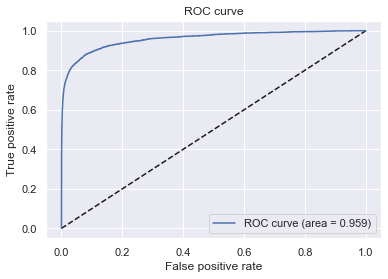

AUC 0.9586859243421825


In [103]:
predict_evaluate(x_test, y_test, clf) 

#### Results & Scores 

The following AUC scores were recorded in this section to keep track of what improved or hindered the model. Running the code above was an iterative process using subsets of the data. Only the full dataset was used to create the final AUC score.

AUC 0.8817784932892847 - features above 2000

Change feature importance cut-off to anything above zero; AUC 0.8632441366254316

AUC 0.8632441366254316 - features above 1000

AUC 0.8632441366254316 - features above 2000

AUC 0.8697787690593446 - back fill M4

AUC 0.8634323310582304 - forward fill M4

AUC 0.8697787690593446 -switched M4 back to back fill 

AUC 0.8371680278155098 - added M5 back fill

AUC 0.8410791180575354 - changed M5 to forward fill

AUC 0.8706768850653744 - removed M5 fill and added M6 forward fill

AUC 0.867451493350774 - changed  M6 to back fill

AUC 0.8575889870853899 - changed  M6 to back forward fill, added back fill for card4

AUC 0.8706768850653744 - removed back fill for card4

AUC 0.8673136083208026 - added addr1 backfill

AUC 0.8690912072207035 - removed addr1 and added addr2 backfill

AUC 0.8669577158785793 - changed addr2 to forward fill

AUC 0.8706768850653744 - removed addr2 fill

AUC 0.8333789844581211 - added f fill for card6

AUC 0.8706768850653744 - removed card6 fill

AUC 0.8580082321089516 - with new dataset of 20,000

AUC 0.9586859243421825 - when trained on entire set.

In [106]:

clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.75, bagging_seed=11, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.75,
               importance_type='split', learning_rate=0.01, max_depth=-1,
               metric='auc', min_child_samples=20, min_child_weight=0.03,
               min_data_in_leaf=20, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1000, num_leaves=350,
               objective='binary', random_state=47, reg_alpha=0.5, reg_lambda=1,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, tree_learner='serial', verbosity=-1)

Confusion Matrix
[[113919    137]
 [  1677   2375]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    114056
           1       0.95      0.59      0.72      4052

    accuracy                           0.98    118108
   macro avg       0.97      0.79      0.86    118108
weighted avg       0.98      0.98      0.98    118108

Accuracy Score 0.9846411758729299


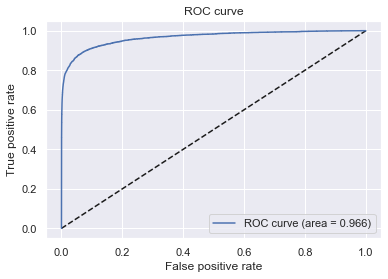

AUC 0.965834408355266


In [108]:
predict_evaluate(x_test, y_test, clf) 

In [107]:
yhat_ul = clf.predict_proba(test_X)

#### Create the submission file

Since we had TransactionId as our index, we were able to write this, along with our isFraud probability prediction to a csv file using index = True

In [112]:
test_X['isFraud']=yhat_ul[:, 1]
test_X[["isFraud"]].to_csv("submission.csv",index=True)

#### Score from Kaggle

After submitting this csv file (prediction results) to Kaggle, I obtained the following scores;

Private Score: 0.905589

Public Score:  0.937381